#### Lee Lab Interview Notebook

In this notebook, we briefly explore several different methods of performing 2D image registration, in increasing order of difficulty

##### Setup

In [ ]:
import os
import numpy
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# TODO: please only use NumPy and SciPy packages for the following exercises, but feel free to import any missing NumPy or SciPy subpackages here
!pip install --quiet SimpleITK #used for image transformation // not gradient descent
import SimpleITK as sitk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.9 MB/s eta 0:00:00


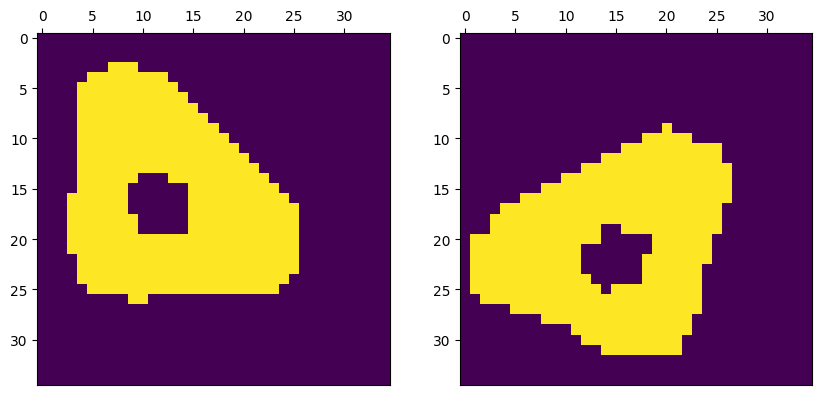

In [ ]:
## Construct two binary images
source_img = np.array([[0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,1,1,1,0,0,0],[0,1,0,1,1,0,0],[0,1,1,1,1,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
source_img = scipy.ndimage.zoom(source_img, 5)
target_img = scipy.ndimage.rotate(source_img, 72, reshape = False)

def check_results(img1, img2, points1 = [], points2 = []):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.imshow(img1); ax1.xaxis.tick_top()
    ax2.imshow(img2); ax2.xaxis.tick_top()
    for p1, p2 in zip(points1, points2):
        fig.add_artist(ConnectionPatch(p1, p2, 'data', 'data', axesA=ax1, axesB=ax2, mutation_scale = 20, color = 'green', arrowstyle='-|>'));

check_results(source_img, target_img)

##### Method 1: Brute force alignment
This brute force method should iterate through all angles and computes the mean squared error between the transformed source image and the target image. We simply pick the angle with the minimum mean-squared error.

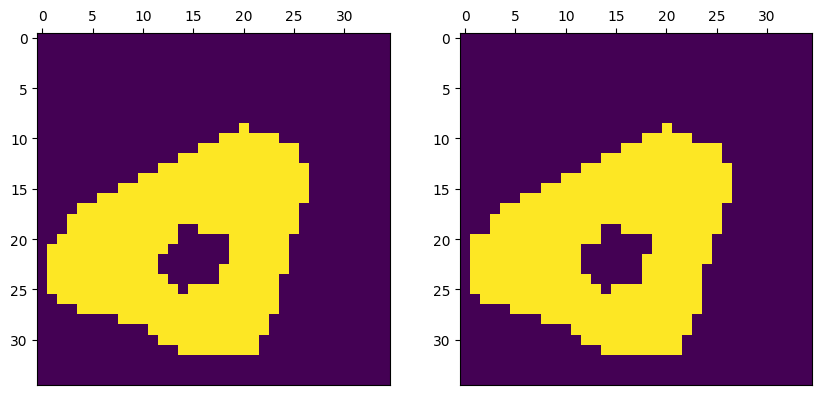

In [ ]:
def apply_angle(img, angle):
    return scipy.ndimage.rotate(img, angle, reshape = False)

def calc_mse(img1, img2):
    #############################################################
    # TODO: implement mean-squared error between the two images #
    #############################################################

    #difference between ytrue and ypred
    diff_img = img1 - img2
    #squared differences
    square_img = np.square(diff_img)
    #average of squares
    error = np.mean(square_img)

    #return
    return error #0
    #############################################################

angles = np.linspace(0, 360, num = 200)
mse_vals = np.zeros(angles.shape)
for idx, angle in enumerate(angles):
    # TODO: rotate `source_img`, compute mean-squared error, and save result

    #rotate the image by angle
    rot_image = apply_angle(source_img, angle)
    #compute
    mse_vals[idx] = calc_mse(target_img, rot_image)

    #pass


## for plotting mse vs. angle
# plt.figure(figsize=(5,5))
# plt.plot(angles, mse_vals);
# plt.xlabel('angle');
# plt.ylabel('mse');

###################################################################
# TODO: pick angle corresponding to the lowest mean squared error #
###################################################################

#determine the lowest mse val
idx = np.argmin(mse_vals)

#set the optimal angle
optim_angle = angles[idx]
###################################################################
source_img_tx1 = apply_angle(source_img, optim_angle)
check_results(source_img_tx1, target_img)

##### Method 2: Least squares

Although the brute force approach works, it is obviously not the optimal approach, especially if the images are more deformed/translated/scaled than this toy example. Instead, if we manually define a few pairs of points that match between the two images, we can use a least squares approach to compute a linear transformation matrix that transforms points from the source to the target image. **Make the solutions generalizable to any transformation (scaling,rotation,translation). Print out your tranformation matrix. Display an image subtraction between target and source.**

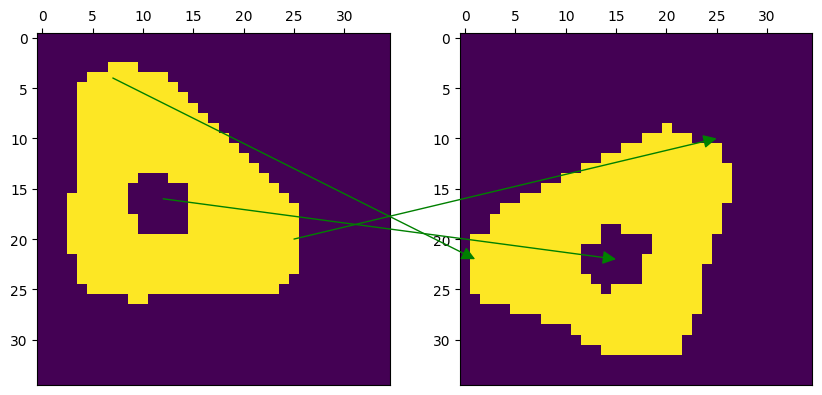

In [ ]:
## Show the mapping between the 3 source points and the 3 target points
source_points = [(12,16),(7,4),(25,20)]
target_points = [(15,22),(1,22),(25,10)]
check_results(source_img, target_img, points1 = source_points, points2 = target_points)

Given A is the source, b is the target, x is the transformation matrix.

1. Ax = b
2. At * Ax = At * b
3. x = (At * A)^-1 * At * b

Using the given source & target points, solve for x and then apply matrix multiplication to all points in source image.

In [ ]:
#implement lease squares
class LeastSquares:
  #init (fitting)
  def __init__(self, source_matrix, target_matrix):
    #ones
    source_matrix = np.append(source_matrix, np.expand_dims(np.ones(source_matrix.shape[0]), 1), 1)
    #zeros
    target_matrix = np.append(target_matrix, np.expand_dims(np.zeros(target_matrix.shape[0]), 1), 1)
    #source transpose multiplied by self
    temp0 = np.matmul(np.transpose(source_matrix), source_matrix)
    #invert
    temp1 = np.linalg.inv(temp0)
    #multiply by source transpose
    temp2 = np.matmul(temp1, np.transpose(source_matrix))
    #multiply by target
    self.trans_matrix = np.matmul(temp2, target_matrix)
  #predict points
  def predict_image(self, source_img):
    #where
    x, y = numpy.where(source_img == 1)
    #concat
    source_matrix2 = np.concatenate((np.expand_dims(y, axis = 1), np.expand_dims(x, axis = 1)), axis = 1)
    #ones
    source_matrix2 = np.append(source_matrix2, np.expand_dims(np.ones(len(y)), 1), 1)
    #check
    y_pred2 = np.matmul(source_matrix2, self.trans_matrix)
    #init empty
    transformed_img = np.zeros(source_img.shape)
    #iterate
    for arr in y_pred2:
      x = int(arr[0])
      y = int(arr[1])
      #set (notice y and then x)
      transformed_img[y, x] = 1
    #return
    return transformed_img

#plotting
def plotter(source_img, trans_img):
  plt.figure(figsize = (20, 20))
  plt.subplot(1, 3, 1)
  plt.imshow(source_img)
  plt.title('Target Transformation')
  plt.subplot(1, 3, 2)
  plt.imshow(trans_img)
  plt.title('Model Transformation')
  plt.subplot(1, 3, 3)
  plt.imshow(source_img - trans_img)
  plt.title('Mask Difference')
  plt.show()

#def transform points
def transform_points(points_matrix, trans_matrix):
  #get points
  points_matrix = np.append(points_matrix, np.expand_dims(np.ones(points_matrix.shape[0]), 1), 1)
  points_matrix = np.matmul(points_matrix, trans_matrix)
  #return
  return points_matrix[:, 0:2]

#transform image
def transform_image(image, trans_matrix):
  #get new target image
  x, y = numpy.where(image == 1)
  #concat
  source_matrix2 = np.concatenate((np.expand_dims(y, axis = 1), np.expand_dims(x, axis = 1)), axis = 1)
  #apply transform
  source_matrix2 = transform_points(source_matrix2, trans_matrix)
  #init empty
  transformed_img = np.zeros(source_img.shape)
  #iterate
  for arr in source_matrix2:
    x = int(arr[0])
    y = int(arr[1])
    #set (notice y and then x)
    transformed_img[y, x] = 1
  #return
  return transformed_img

#transform
def transform(source_matrix, source_img, trans_matrix):
  target_matrix = transform_points(source_matrix, trans_matrix)
  target_img = transform_image(source_img, trans_matrix)
  #return
  return target_matrix, target_img

#convert from list to array
source_matrix = np.array(source_points)
target_matrix = np.array(target_points)

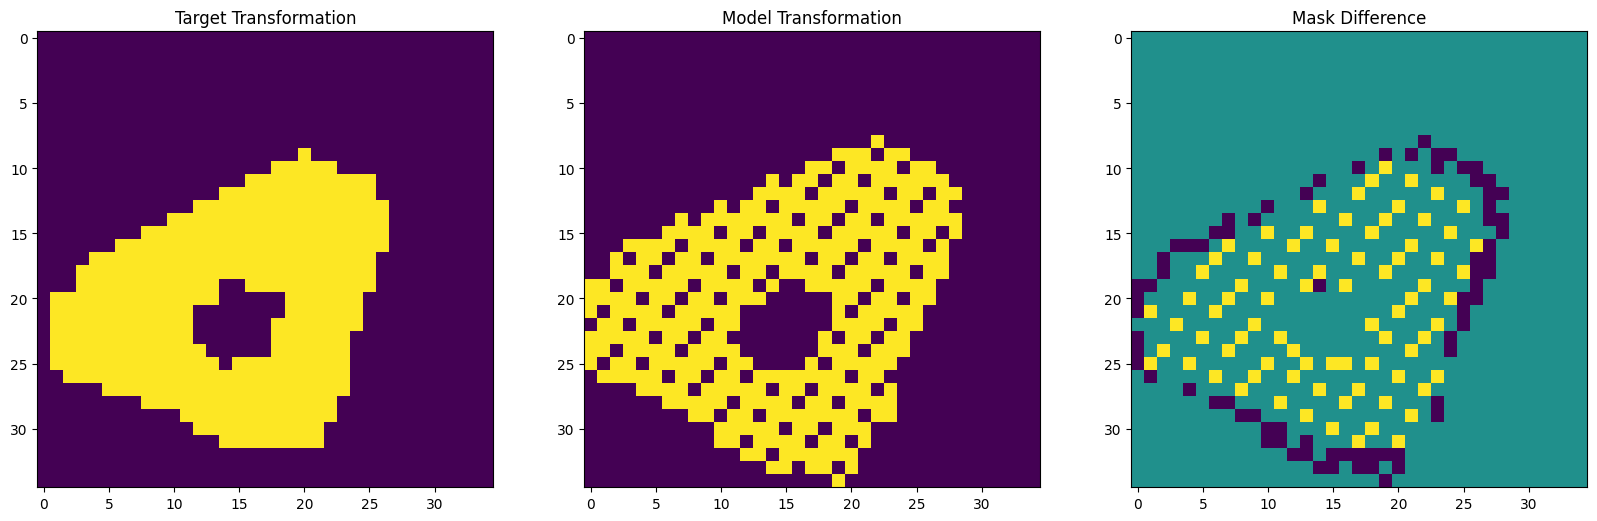

[[ 0.47058824 -1.05882353  0.        ]
 [ 0.97058824  0.44117647  0.        ]
 [-6.17647059 27.64705882  0.        ]]


In [ ]:
#Simple Transform

#fit
lsq_model = LeastSquares(source_matrix, target_matrix)
#infer
trans_img = lsq_model.predict_image(source_img)
#plot
plotter(target_img, trans_img)
#print
print(lsq_model.trans_matrix)

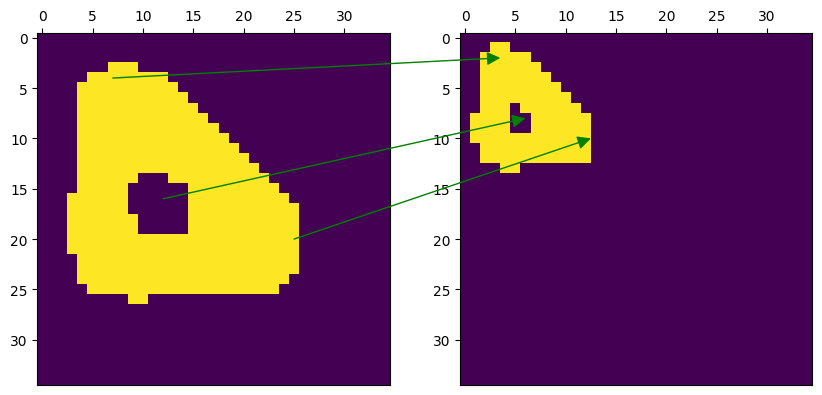

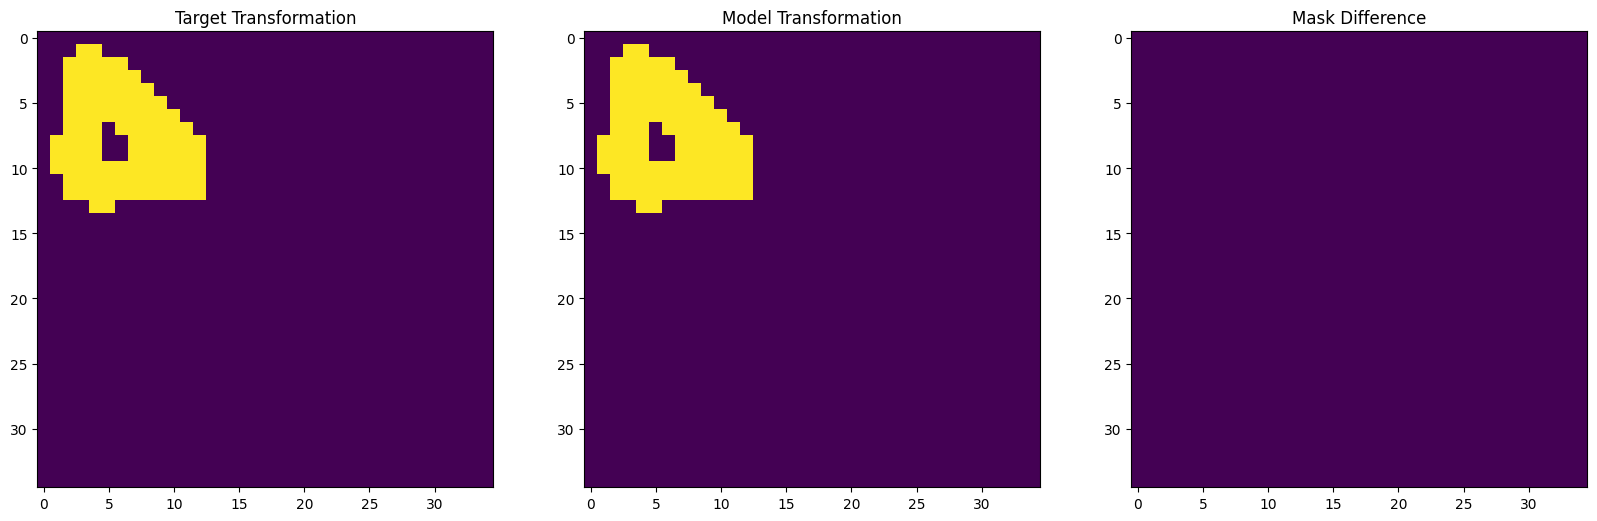

[[5.0000000e-01 4.4408921e-16 0.0000000e+00]
 [8.8817842e-16 5.0000000e-01 0.0000000e+00]
 [0.0000000e+00 8.8817842e-16 0.0000000e+00]]


In [ ]:
#Scaling Transform

#scaling transform
scale = 0.5
scaling_matrix = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]])
#apply to input data
scaled_target_matrix, scaled_target_img = transform(source_matrix, source_img, scaling_matrix)
#plot
check_results(source_img, scaled_target_img, points1 = source_matrix.tolist(), points2 = scaled_target_matrix.tolist())

#fit
lsq_model = LeastSquares(source_matrix, scaled_target_matrix)
#infer
trans_img = lsq_model.predict_image(source_img)
#plot
plotter(scaled_target_img, trans_img)
#print
print(lsq_model.trans_matrix)

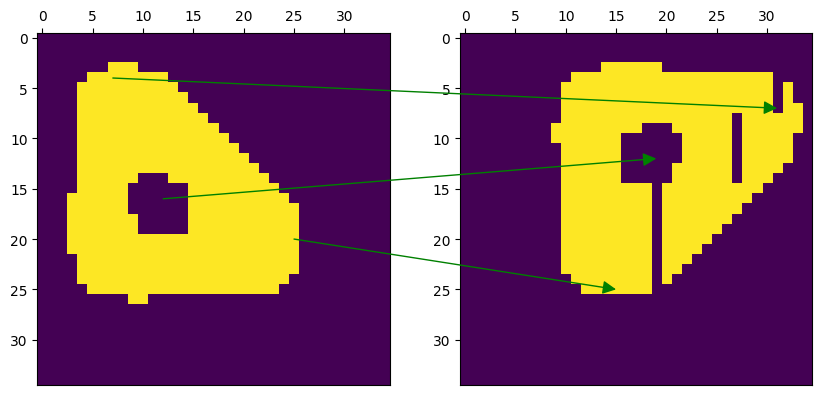

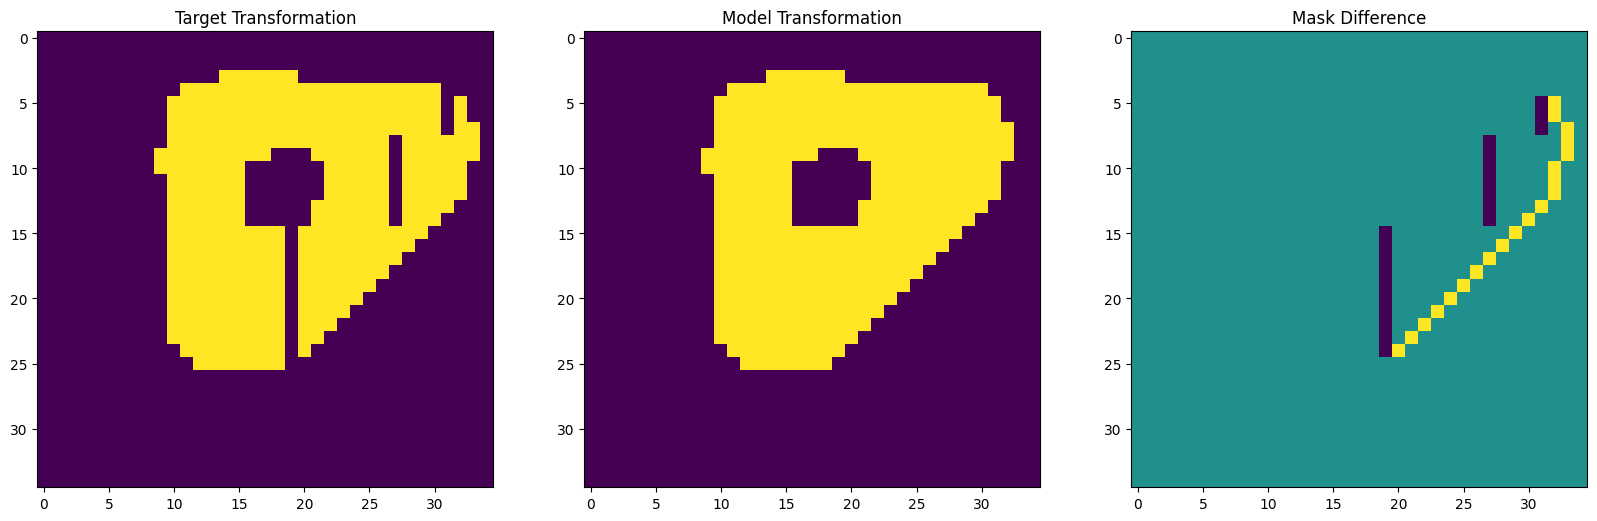

[[-8.88178420e-16  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  1.99840144e-15  0.00000000e+00]
 [-1.77635684e-15  0.00000000e+00  0.00000000e+00]]


In [ ]:
#Rotation Transform

#scaling transform
theta = -np.pi / 2
rot_matrix = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
#apply to input data
rot_target_matrix, rot_target_img = transform(source_matrix, source_img, rot_matrix)
#hardcoded for visual purposes // no impact on results // rectifies frame of reference
#rot_target_matrix[:, 0] = rot_target_matrix[:, 0] + source_img.shape[0]
mod_rot_target_matrix = np.copy(rot_target_matrix)
mod_rot_target_matrix[:, 0] = mod_rot_target_matrix[:, 0] + source_img.shape[0]
#plot
check_results(source_img, rot_target_img, points1 = source_matrix.tolist(), points2 = mod_rot_target_matrix.tolist())

#fit
lsq_model = LeastSquares(source_matrix, rot_target_matrix)
#infer
trans_img = lsq_model.predict_image(source_img)
#plot
plotter(rot_target_img, trans_img)
#print
print(lsq_model.trans_matrix)

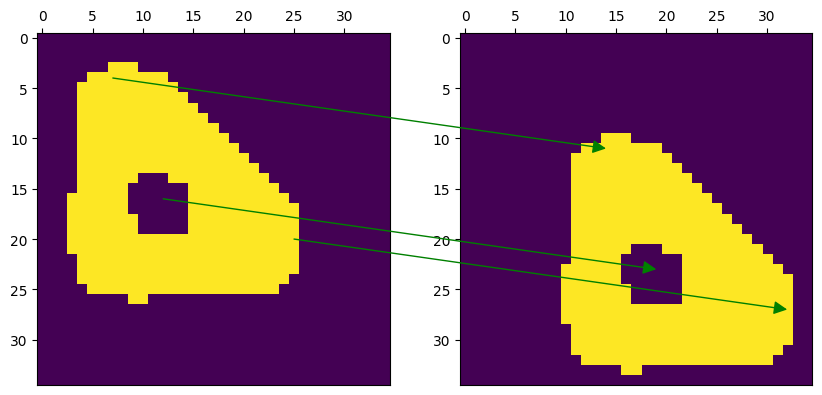

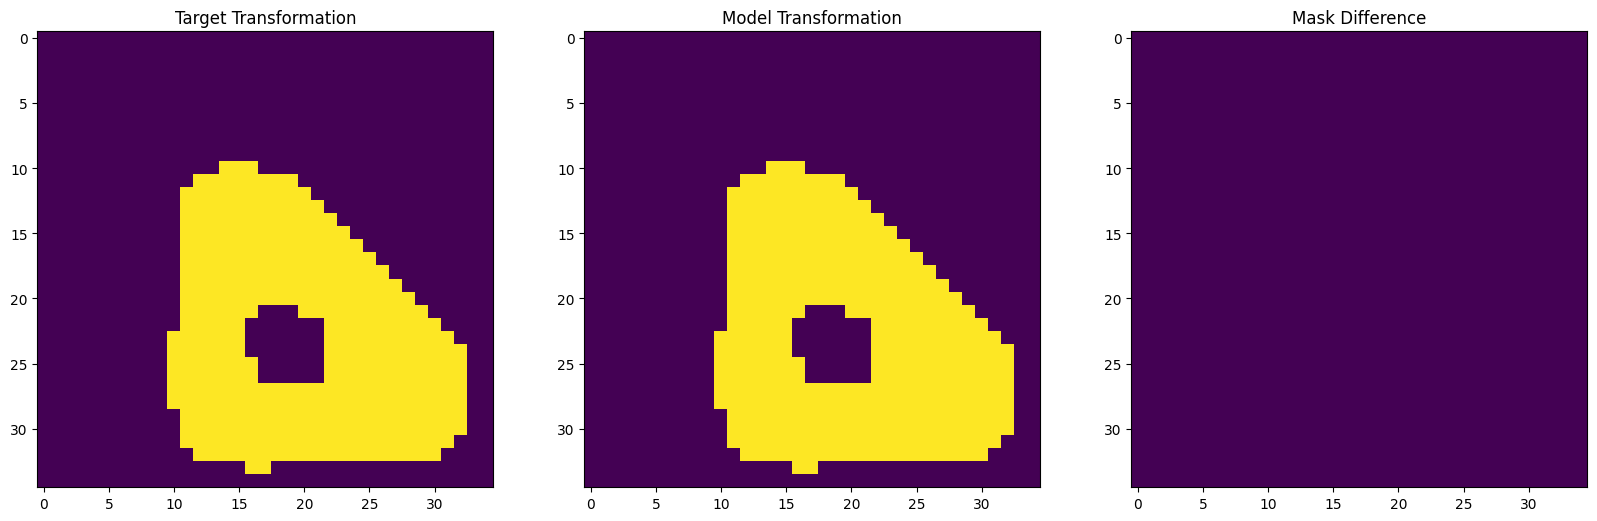

[[1.00000000e+00 1.11022302e-15 0.00000000e+00]
 [2.22044605e-15 1.00000000e+00 0.00000000e+00]
 [7.00000000e+00 7.00000000e+00 0.00000000e+00]]


In [ ]:
#Translation Transform

#translation transform
dx = 7
dy = 7
translation_matrix = np.array([[1, 0, 0], [0, 1, 0], [dx, dy, 1]])
#apply to input data
translation_target_matrix, translation_target_img = transform(source_matrix, source_img, translation_matrix)
#plot
check_results(source_img, translation_target_img, points1 = source_matrix.tolist(), points2 = translation_target_matrix.tolist())

#fit
lsq_model = LeastSquares(source_matrix, translation_target_matrix)
#infer
trans_img = lsq_model.predict_image(source_img)
#plot
plotter(translation_target_img, trans_img)
#print
print(lsq_model.trans_matrix)

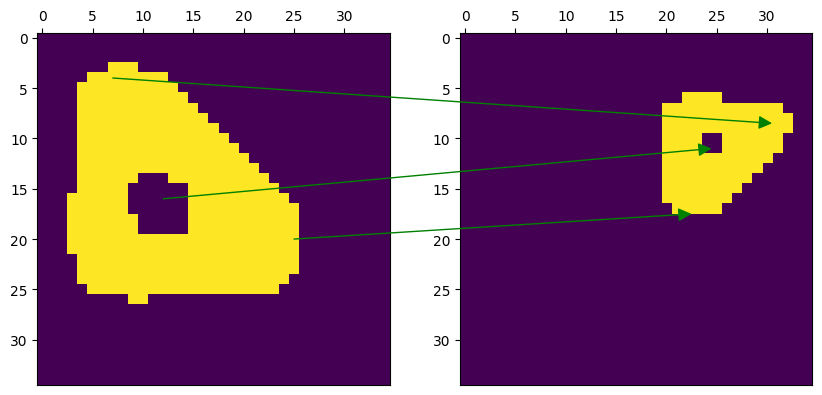

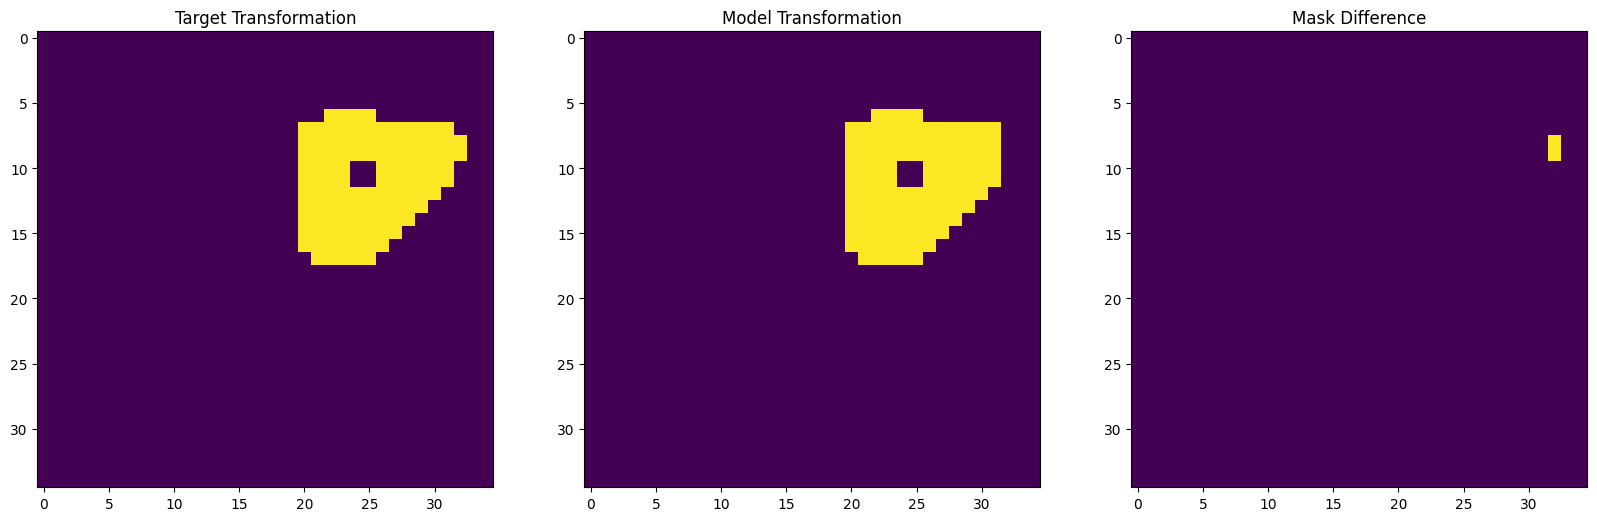

[[-5.55111512e-16  5.00000000e-01  0.00000000e+00]
 [-5.00000000e-01  1.22124533e-15  0.00000000e+00]
 [-2.50000000e+00  5.00000000e+00  0.00000000e+00]]


In [ ]:
#All Transform

#translation
dx = 10
dy = 5
translation_matrix = np.array([[1, 0, 0], [0, 1, 0], [dx, dy, 1]])
#rotation
theta = -np.pi / 2
rot_matrix = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
#scaling
scale = 0.5
scaling_matrix = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]])
#combine
all_matrix = translation_matrix @ rot_matrix @ scaling_matrix
#apply to input data
all_target_matrix, all_target_img = transform(source_matrix, source_img, all_matrix)
#hardcoded for visual purposes // no impact on results // rectifies frame of reference
#all_target_matrix[:, 0] = all_target_matrix[:, 0] + source_img.shape[0]
mod_all_target_matrix = np.copy(all_target_matrix)
mod_all_target_matrix[:, 0] = mod_all_target_matrix[:, 0] + source_img.shape[0]
#plot
check_results(source_img, all_target_img, points1 = source_matrix.tolist(), points2 = mod_all_target_matrix.tolist())

#fit
lsq_model = LeastSquares(source_matrix, all_target_matrix)
#infer
trans_img = lsq_model.predict_image(source_img)
#plot
plotter(all_target_img, trans_img)
#print
print(lsq_model.trans_matrix)

##### Method 3: Optimization

If we don't have a list of points but still want a transformation matrix, an alternative is an optimization approach, such as gradient descent.
We need to first define a similarity metric to minimize between the two images (for example: mean-squared error), and then we compute the gradient of this metric with respect to each of our transformation matrix elements. In each iteration of this algorithm, we apply an update to each matrix element based on the gradient value. **Make the solutions generalizable to any transformation (scaling,rotation,translation). Print out your tranformation matrix. Display an image subtraction between target and source.**

You can read more about SciPy's built-in optimizers here
https://docs.scipy.org/doc/scipy/tutorial/optimize.html

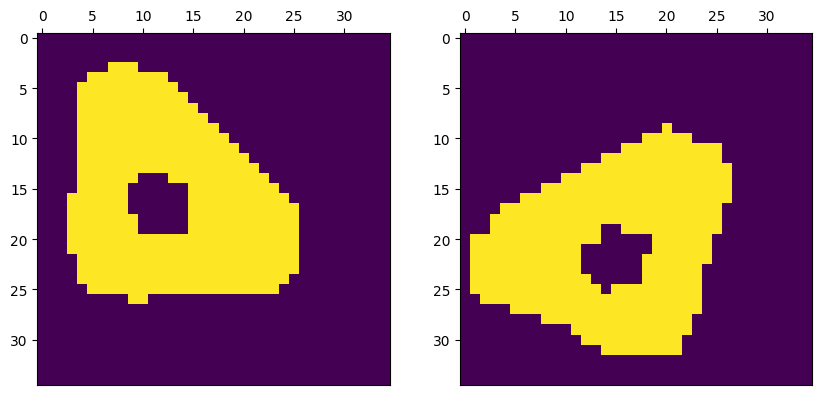

In [ ]:
###################################################################################################################################
# TODO: this exercise is more open-ended. Feel free to use any built-in gradient-based optimizer available through NumPy or SciPy #
###################################################################################################################################
trans_matrix = None
source_img_tx3 = source_img
###################################################################################################################################

check_results(source_img_tx3, target_img) # the images should (almost) look the same

Iteration 1 of 15: MSE 0.24
Iteration 2 of 15: MSE 0.2
Iteration 3 of 15: MSE 0.19
Iteration 4 of 15: MSE 0.18
Iteration 5 of 15: MSE 0.18
Iteration 6 of 15: MSE 0.18
Iteration 7 of 15: MSE 0.18
Iteration 8 of 15: MSE 0.18
Iteration 9 of 15: MSE 0.18
Iteration 10 of 15: MSE 0.18
Iteration 11 of 15: MSE 0.18
Iteration 12 of 15: MSE 0.18
Iteration 13 of 15: MSE 0.18
Iteration 14 of 15: MSE 0.18
Iteration 15 of 15: MSE 0.18


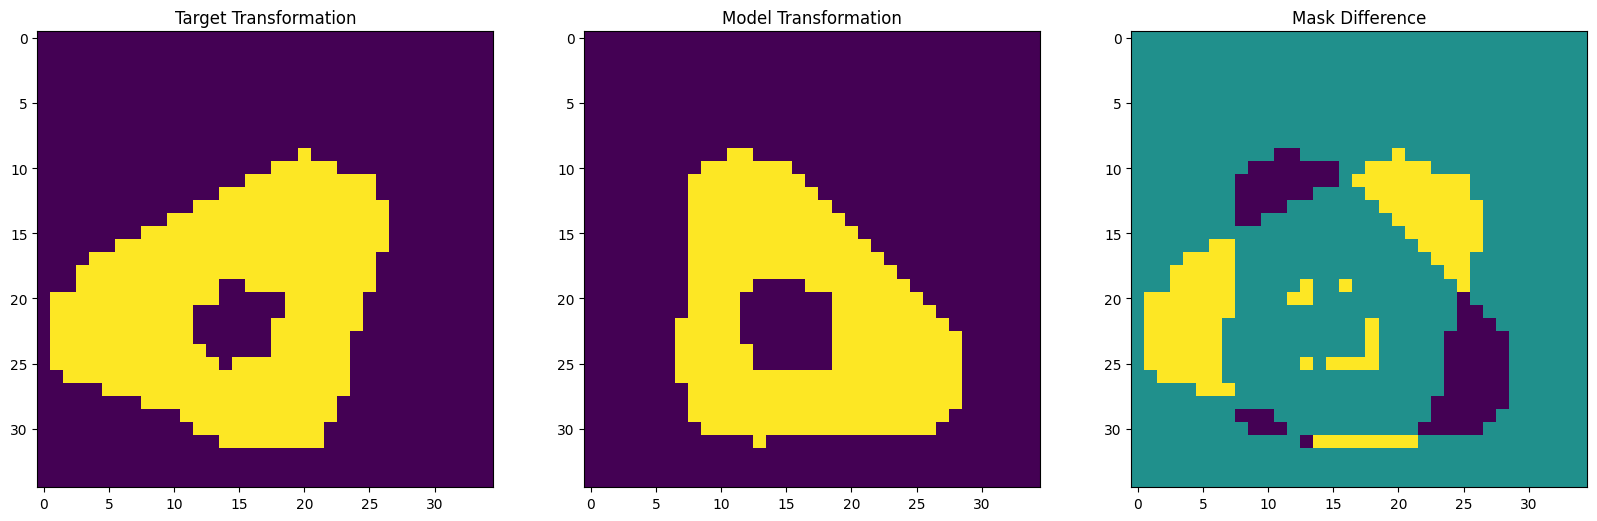

In [ ]:
#translation transform my way
#reference: https://github.com/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example_mse_translation_GradientDescent.ipynb
def init_t(num):
  return np.random.normal(size = (num, 1))

def translate_img(img, t):
  return scipy.ndimage.shift(img, t)

def img_grad(img):
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = scipy.ndimage.convolve(img, SbX2D, mode='constant', cval=0.0)
    dY = scipy.ndimage.convolve(img, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

def get_trans_jac():
  return np.array([[1, 0], [0, 1]])

def compute_grad(u, v):
  #compute grad
  dv = img_grad(v)
  #diff term
  n = 1
  for i in range(len(u.shape)):
    n =  n * u.shape[i]
  dmse = (2/float(n))* (v-u)
  #iterate
  dmdt = np.array([0.0,0.0])
  #iterate
  for i in range(dv.shape[0]):
    for j in range(dv.shape[1]):
      dx = dv[i,j,0]
      dy = dv[i,j,1]
      dp = get_trans_jac()
      dxy0 = np.dot([dx,dy],dp[:,0])
      dxy1 = np.dot([dx,dy],dp[:,1])
      dmdt[0] = dmdt[0] + dmse[i,j]*dxy0
      dmdt[1] = dmdt[1] + dmse[i,j]*dxy1
  #return
  return np.expand_dims(np.array([dmdt[0], dmdt[1]]), axis = 1)

def imTransform(imgA,tPars):
  img = sitk.GetImageFromArray(imgA)
  origin = img.GetOrigin()
  img.SetOrigin((0,0,0))
  transform = sitk.TranslationTransform(2)
  transform.SetParameters(tPars)
  outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
  outimage.SetOrigin(origin)
  resultImage = sitk.GetArrayFromImage(outimage)
  return resultImage

def prep(t):
  eles = []
  for ele in t.tolist():
    eles.append(ele[0])
  return eles

#define optimizer
class TranslationOptimizer:
  #init
  def __init__(self, u, v, lr = 10, iter = 10):
    #train
    self.t = init_t(2)
    #lr
    lr = 10
    #iter
    iter = 15
    #iterate
    for i in range(iter):
      #transform moving image
      v_t = imTransform(v, prep(self.t))
      #v_t = scipy.ndimage.shift(v, self.t) #with scipy the mse increases // scipy[10, 10] == simpleitk[-10, -10] reverse coordinates
      #compute mse
      mse = calc_mse(v_t, u)
      #compute grad
      grad = compute_grad(u, v_t)
      #update
      self.t = self.t - lr * grad
      #print
      print('Iteration {0} of {1}: MSE {2:.2g}'.format(i + 1, iter, mse))
  #predict
  def infer(self, v):
    #transform moving image
    return imTransform(v, prep(self.t))

#train
opt = TranslationOptimizer(target_img, source_img)
#plot
plotter(target_img, opt.infer(source_img))


Iteration 1 of 10: MSE 0.27
Iteration 2 of 10: MSE 0.3
Iteration 3 of 10: MSE 0.3
Iteration 4 of 10: MSE 0.3
Iteration 5 of 10: MSE 0.3
Iteration 6 of 10: MSE 0.3
Iteration 7 of 10: MSE 0.3
Iteration 8 of 10: MSE 0.3
Iteration 9 of 10: MSE 0.3
Iteration 10 of 10: MSE 0.3


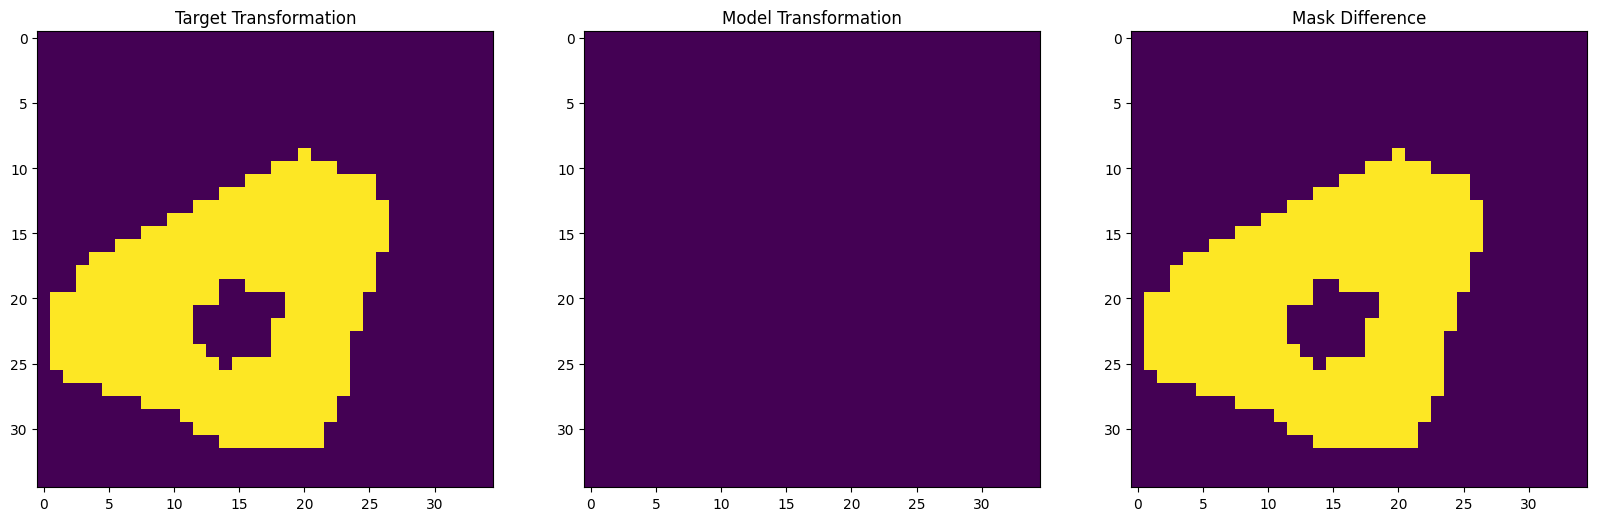

In [ ]:
#affine transform custom
#refer: https://maelfabien.github.io/computervision/cv_5/#2-affine-transformation

def init_ident(num):
  t = np.zeros((num, 1))
  t[0] = 1
  t[4] = 1
  return t

def itk_affine_transform(img, t):
  affine_mat = t.squeeze().tolist() + [0, 0, 1]
  affine_mat = (0.5, 0, 5, 0, 0.5, 5, 0, 0, 1)
  img = np.expand_dims(img, axis = 2)
  img = sitk.GetImageFromArray(img)
  img.SetOrigin((0,0,0))
  transform = sitk.AffineTransform(3)
  transform.SetMatrix(affine_mat)
  transform.SetCenter((0, 0, 0))
  outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
  outimage.SetOrigin((0, 0, 0))
  resultImage = sitk.GetArrayFromImage(outimage)
  return resultImage.squeeze(2)

#affine jacobian
def get_aff_jac(x, y):
  return np.array([[1, 0, x, y, 0, 0],[0, 1, 0, 0, x, y]])
  #return np.array([[1, 0, x, y, 0, 0],[0, 1, 0, 0, x, y]])

#compute grad
def compute_grad_aff(u, v):
  #im grad
  dv = img_grad(v)
  #diff term
  n = 1
  for i in range(len(u.shape)):
    n =  n * u.shape[i]
  dmse = (2/float(n))* (v-u)

  #init
  dmdt = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
  #iterate
  for i in range(dv.shape[0]):
    for j in range(dv.shape[1]):
      dx = dv[i,j,0]
      dy = dv[i,j,1]
      dp = get_aff_jac(i, j)
      #dxy
      dxy0 = np.dot([dx,dy],dp[:,0])
      dxy1 = np.dot([dx,dy],dp[:,1])
      dxy2 = np.dot([dx,dy],dp[:,2])
      dxy3 = np.dot([dx,dy],dp[:,3])
      dxy4 = np.dot([dx,dy],dp[:,4])
      dxy5 = np.dot([dx,dy],dp[:,5])
      #sum
      dmdt[0] = dmdt[0] + dmse[i,j]*dxy0
      dmdt[1] = dmdt[1] + dmse[i,j]*dxy1
      dmdt[2] = dmdt[2] + dmse[i,j]*dxy2
      dmdt[3] = dmdt[3] + dmse[i,j]*dxy3
      dmdt[4] = dmdt[4] + dmse[i,j]*dxy4
      dmdt[5] = dmdt[5] + dmse[i,j]*dxy5
  #return
  return np.expand_dims(np.array([dmdt[0], dmdt[1], dmdt[2], dmdt[3], dmdt[4], dmdt[5]]), axis = 1)

def scipy_affine_transform(img, t):
  mat = np.concatenate([t.reshape(2, 3), np.expand_dims(np.array([0, 0, 1]), axis = 0)])
  return scipy.ndimage.affine_transform(source_img, mat)

class AffineOptimizer:
  #init
  def __init__(self, u, v, lr = 1, iter = 10):
    #init
    self.t = init_ident(6)
    #iterate
    for i in range(iter):
      #transform
      #v_t = itk_affine_transform(v, t)
      v_t = scipy_affine_transform(v, self.t)
      #calculate mse
      mse = calc_mse(v_t, u)
      #compute grad for affine
      grad = compute_grad_aff(u, v_t)
      #update
      self.t = self.t - lr * grad
      #print
      print('Iteration {0} of {1}: MSE {2:.2g}'.format(i + 1, iter, mse))
  #infer
  def infer(self, v):
    return scipy_affine_transform(v, self.t)

#train
opt = AffineOptimizer(target_img, source_img)
#plot
plotter(target_img, opt.infer(source_img))


In [ ]:
stop
#init
t = init_ident(6)
#lr
lr = 1e1
#iter
iter = 10

#set
u = target_img
v = source_img

#iterate
for i in range(iter):
  #transform
  #v_t = itk_affine_transform(v, t)
  v_t = scipy_affine_transform(v, t)

  #calculate mse
  mse = calc_mse(v_t, u)
  #compute grad for affine
  grad = compute_grad_aff(u, v_t)
  #update
  t = t - lr * grad
  #print
  print('Iteration {0} of {1}: MSE {2:.2g}'.format(i + 1, iter, mse))


NameError: ignored

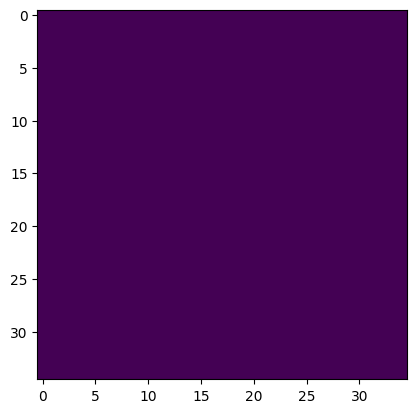

In [ ]:
plt.imshow(v_t)

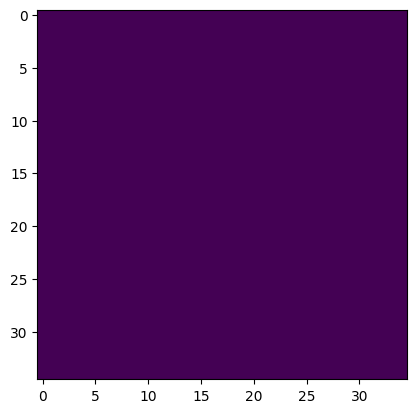

In [ ]:
plt.imshow(scipy_affine_transform(v, t))

In [ ]:
mat = np.array([[5, 0, -5], [0, 5, -5], [0, 0, 1]])

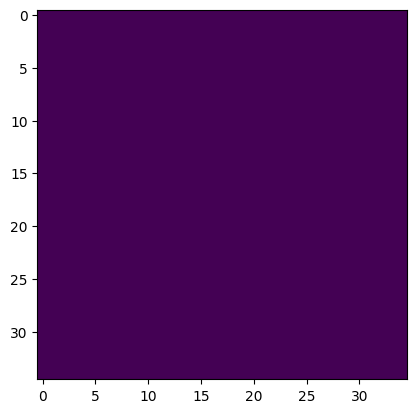

In [ ]:
plt.imshow(itk_affine_transform(v, t))

In [ ]:
out = np.expand_dims(dv[15, 15], axis = 0) @ dp

NameError: ignored

In [ ]:
out

In [ ]:
dx = dv[15,15,0]
dy = dv[15,15,1]
dp = get_aff_jac(i, j)

dxy0 = np.dot([dx,dy],dp[:,0])
dxy1 = np.dot([dx,dy],dp[:,1])
dxy2 = np.dot([dx,dy],dp[:,2])
dxy3 = np.dot([dx,dy],dp[:,3])
dxy4 = np.dot([dx,dy],dp[:,4])
dxy5 = np.dot([dx,dy],dp[:,5])


In [ ]:
t.shape

In [ ]:
dp.shape

In [ ]:
def compute_masked_grad(u, v):
  dv = img_grad(v)
  dmdt = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

  for i in range(dv.shape[0]):
    for j in range(dv.shape[1]):
      if u[i, j] == 1:
        diff = v[i, j] - u[i, j]
        dx = dv[i,j,0]
        dy = dv[i,j,1]
        #dxy
        dxy0 = np.dot([dx,dy],dp[:,0])
        dxy1 = np.dot([dx,dy],dp[:,1])
        dxy2 = np.dot([dx,dy],dp[:,2])
        dxy3 = np.dot([dx,dy],dp[:,3])
        dxy4 = np.dot([dx,dy],dp[:,4])
        dxy5 = np.dot([dx,dy],dp[:,5])
        #sum
        dmdt[0] = dmdt[0] + diff*dxy0
        dmdt[1] = dmdt[1] + diff*dxy1
        dmdt[2] = dmdt[2] + diff*dxy2
        dmdt[3] = dmdt[3] + diff*dxy3
        dmdt[4] = dmdt[4] + diff*dxy4
        dmdt[5] = dmdt[5] + diff*dxy5

  _, counts = np.unique(u, return_counts = True)
  dmdt = dmdt * 2 / counts[1]
  return np.expand_dims(np.array([dmdt[0], dmdt[1], dmdt[2], dmdt[3], dmdt[4], dmdt[5]]), axis = 1)

In [ ]:

#im grad
dv = img_grad(v)
#diff term
n = 1
for i in range(len(u.shape)):
  n =  n * u.shape[i]
dmse = (2/float(n))* (v-u)

#init
dmdt = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#iterate
for i in range(dv.shape[0]):
  for j in range(dv.shape[1]):
    dx = dv[i,j,0]
    dy = dv[i,j,1]
    dp = get_aff_jac(i, j)
    #dxy
    dxy0 = np.dot([dx,dy],dp[:,0])
    dxy1 = np.dot([dx,dy],dp[:,1])
    dxy2 = np.dot([dx,dy],dp[:,2])
    dxy3 = np.dot([dx,dy],dp[:,3])
    dxy4 = np.dot([dx,dy],dp[:,4])
    dxy5 = np.dot([dx,dy],dp[:,5])
    #sum
    dmdt[0] = dmdt[0] + dmse[i,j]*dxy0
    dmdt[1] = dmdt[1] + dmse[i,j]*dxy1
    dmdt[2] = dmdt[2] + dmse[i,j]*dxy2
    dmdt[3] = dmdt[3] + dmse[i,j]*dxy3
    dmdt[4] = dmdt[4] + dmse[i,j]*dxy4
    dmdt[5] = dmdt[5] + dmse[i,j]*dxy5
#return
#return np.expand_dims(np.array([dmdt[0], dmdt[1], dmdt[2], dmdt[3], dmdt[4], dmdt[5]]), axis = 1)

In [ ]:
def get_img_points(source_img):
  k = 0
  h, w = source_img.shape
  points = np.zeros((int(h * w), 3))
  for i in range(source_img.shape[0]):
    for j in range(source_img.shape[1]):
      val = source_img[i, j]
      points[k, :] = np.array([i, j, val])
      k = k + 1
  return points

def get_b_points(b, source_matrix):
  #init
  target_matrix = np.zeros(source_matrix.shape)
  #z
  z = 0
  #iterate
  for i in range(0, b.shape[0], 2):
    #subset
    f = b[i:i+2]
    #insert
    target_matrix[z, 0:2] = f.T.squeeze(0)
    #add
    z = z + 1
  #insert the actual image volumes
  target_matrix[:, 2] = source_matrix[:, 2]
  #return
  return target_matrix

In [ ]:
#new mwethod
t = init_t(6)
#get source points
source_points = get_img_points(source_img)
#set source matrix
A = get_A(source_points)
#compute
b = A @ t
#get b points
pred_points = get_b_points(b, source_points)
#get image this way?
v_t = itk_affine_transform(source_img, t)
#get grad
grad = compute_grad(t, v_t, source_points, target_img, pred_points)




In [ ]:
grad

In [ ]:
A.shape

In [ ]:
pred_points

In [ ]:
#new method with jacobian
def init_t(num):
  return np.random.random((num, 1))

def get_points(source_img):
  k = 0
  h, w = source_img.shape
  points = np.zeros((int(h * w), 3))
  for i in range(source_img.shape[0]):
    for j in range(source_img.shape[1]):
      val = source_img[i, j]
      points[k, :] = np.array([i, j, val])
      k = k + 1
  return points

def interleave(a, b):
  c = np.empty((a.shape[0] + b.shape[0], a.shape[1]), dtype=a.dtype)
  c[0::2] = a
  c[1::2] = b
  return c

def get_A(source_matrix):
  #prepare source points
  source_matrix2 = np.concatenate([source_matrix[:, 0:2], np.ones((source_matrix.shape[0], 1))], axis = 1)
  #prepare zeros
  zero_matrix = np.zeros(source_matrix2.shape)
  #interleave1
  in1 = interleave(source_matrix2, zero_matrix)
  #interleave 2
  in2 = interleave(zero_matrix, source_matrix2)
  #concat
  return np.concatenate([in1, in2], axis = 1)

def get_target_points(b, source_matrix):
  #init
  target_matrix = np.zeros(source_matrix.shape)
  #z
  z = 0
  #iterate
  for i in range(0, b.shape[0], 2):
    #subset
    f = b[i:i+2]
    #insert
    target_matrix[z, 0:2] = f.T.squeeze(0)
    #add
    z = z + 1
  #insert the actual image volumes
  target_matrix[:, 2] = source_matrix[:, 2]
  #return
  return target_matrix


def get_target_img(source_img, target_matrix):
  #convert the target matrix to image
  target_img = np.zeros(source_img.shape)
  #iterate
  for target in target_matrix:
    x = int(target[0])
    y = int(target[1])
    #bounds
    if x > 34:
      x = 34
    if x < 0:
      x = 0
    if y > 34:
      y = 34
    if y < 0:
      y = 34
    #set (notice x and then y)
    target_img[x, y] = target[2]
  #return
  return target_img

def img_grad(img):
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = scipy.ndimage.convolve(img, SbX2D, mode='constant', cval=0.0)
    dY = scipy.ndimage.convolve(img, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

def get_jac(x, y):
  return np.array([[1, 0, x, y, 0, 0], [0, 1, 0, 0, x, y]])


def compute_grad(t, pred_img, source_matrix, target_img, pred_points):
  #init
  all_grad = np.zeros(t.shape)
  #pred grad
  pred_grad = img_grad(pred_img)
  #iterate
  for point, pred_point in zip(source_matrix, pred_points):
    #target point
    target_val = target_img[int(point[0]), int(point[1])]
    #pred point
    pred_val = pred_img[int(point[0]), int(point[1])]
    #subtract
    s0 = pred_val - target_val
    #get grad
    s1 = pred_grad[int(point[0]), int(point[1])]
    #get jac
    s2 = get_jac(int(pred_point[0]), int(pred_point[1]))
    #compute grad
    grad = s0 * (np.expand_dims(s1, axis = 0) @ s2).T
    #add
    all_grad = all_grad + grad
  #multiply by 2 and divide
  return 2 * all_grad / source_matrix.shape[0]

def convert(n):
  v = np.concatenate([n.reshape(2, 3), np.zeros((1, 3))], axis = 0)
  v[2, 2] = 1
  return v

def alternate_compute(t, source_matrix, source_img):
  t0 = convert(t)
  f = t0 @ source_matrix.T
  pred_img = get_target_img(source_img, f.T)
  return pred_img

def get_jac2(x, y):
  return np.array([[0, 0, 0, x, y, 1], [x, y, 1, 0, 0, 0]])

In [ ]:
#other format of getting
def transform_img_scipy(img, t):
  temp = np.concatenate([t.reshape(2, 3), np.zeros((1, 3))])
  temp[2, 2] = 1
  return scipy.ndimage.affine_transform(img, temp)



In [ ]:
#init
t = init_t(6)
#lr
lr = 1
#iter
iter = 100

#set
u = target_img
v = source_img

#iterate
for i in range(iter):
  #transform
  v_t = transform_img_scipy(v, t)
  #calculate mse
  mse = calc_mse(v_t, u)
  #compute grad for affine
  grad = compute_grad_aff(u, v_t)
  #update
  t = t - lr * grad

In [ ]:
scipy.ndimage.geometric_transform(input, affine_mat)

In [ ]:
input = np.array([[2, 3, 5, 6],[2, 3, 5, 6],[1, 1, 1, 1]])

In [ ]:
input

In [ ]:
affine_mat @ input

In [ ]:
temp

In [ ]:
affine_mat

In [ ]:
temp = np.concatenate([t.reshape(2, 3), np.zeros((1, 3))])
temp[2, 2] = 1

In [ ]:
temp.shape

In [ ]:
#is the affine any different? yes
affine_mat = np.array([[0.5, -0.5, 0.5], [0.5, 0.5, 0.6], [0, 0, 1]])
#scipy
plt.imshow(scipy.ndimage.affine_transform(source_img, temp))

In [ ]:
def itk_affine_transform(img, t):
  affine_mat = t.squeeze().tolist() + [0, 0, 1]
  #affine_mat = (0.5, -0.5, 0.5, 0.5, 0.5, 0.6, 0, 0, 1)
  img = np.expand_dims(img, axis = 2)
  img = sitk.GetImageFromArray(img)
  img.SetOrigin((0,0,0))
  transform = sitk.AffineTransform(3)
  transform.SetMatrix(affine_mat)
  transform.SetCenter((0, 0, 0))
  outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
  outimage.SetOrigin((0, 0, 0))
  resultImage = sitk.GetArrayFromImage(outimage)
  return resultImage.squeeze(2)

def get_aff_jac(x, y):
  return np.array([[1, 0, x, y, 0, 0],[0, 1, 0, 0, x, y]])

In [ ]:
#init
t = init_t(6)
#t = np.array([[0.05, -0.5, 0, -0.5, 0.01, 0]]).T
#lr
lr = 10
#iter
iter = 0

#set
u = target_img
v = source_img

#iterate
for i in range(iter):
  #transform
  v_t = itk_affine_transform(v, t)
  #calculate mse
  mse = calc_mse(v_t, u)
  #compute grad for affine
  grad = compute_grad_aff(u, v_t)
  #update
  t = t - lr * grad

In [ ]:
grad[0]

In [ ]:
#compute grad
t = init_t(6)
#set
u = target_img
v = source_img

v_t = itk_affine_transform(v, t)

v = v_t
#im grad
dv = img_grad(v)
#diff term
n = 1
for i in range(len(u.shape)):
  n =  n * u.shape[i]
dmse = (2/float(n))* (v-u)

#init
dmdt = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#iterate
for i in range(dv.shape[0]):
  for j in range(dv.shape[1]):
    dx = dv[i,j,0]
    dy = dv[i,j,1]
    dp = get_aff_jac(dx, dy)
    #dxy
    dxy0 = np.dot([dx,dy],dp[:,0])
    dxy1 = np.dot([dx,dy],dp[:,1])
    dxy2 = np.dot([dx,dy],dp[:,2])
    dxy3 = np.dot([dx,dy],dp[:,3])
    dxy4 = np.dot([dx,dy],dp[:,4])
    dxy5 = np.dot([dx,dy],dp[:,5])
    #sum
    dmdt[0] = dmdt[0] + dmse[i,j]*dxy0
    dmdt[1] = dmdt[1] + dmse[i,j]*dxy1
    dmdt[2] = dmdt[2] + dmse[i,j]*dxy2
    dmdt[3] = dmdt[3] + dmse[i,j]*dxy3
    dmdt[4] = dmdt[4] + dmse[i,j]*dxy4
    dmdt[5] = dmdt[5] + dmse[i,j]*dxy5

np.expand_dims(np.array([dmdt[0], dmdt[1], dmdt[2], dmdt[3], dmdt[4], dmdt[5]]), axis = 1)

In [ ]:
#compute grad
def compute_grad_aff(u, v):
  #im grad
  dv = img_grad(v)
  #diff term
  n = 1
  for i in range(len(u.shape)):
    n =  n * u.shape[i]
  dmse = (2/float(n))* (v-u)

  #init
  dmdt = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
  #iterate
  for i in range(dv.shape[0]):
    for j in range(dv.shape[1]):
      dx = dv[i,j,0]
      dy = dv[i,j,1]
      dp = get_aff_jac(dx, dy)
      #dxy
      dxy0 = np.dot([dx,dy],dp[:,0])
      dxy1 = np.dot([dx,dy],dp[:,1])
      dxy2 = np.dot([dx,dy],dp[:,2])
      dxy3 = np.dot([dx,dy],dp[:,3])
      dxy4 = np.dot([dx,dy],dp[:,4])
      dxy5 = np.dot([dx,dy],dp[:,5])
      #sum
      dmdt[0] = dmdt[0] + dmse[i,j]*dxy0
      dmdt[1] = dmdt[1] + dmse[i,j]*dxy1
      dmdt[2] = dmdt[2] + dmse[i,j]*dxy2
      dmdt[3] = dmdt[3] + dmse[i,j]*dxy3
      dmdt[4] = dmdt[4] + dmse[i,j]*dxy4
      dmdt[5] = dmdt[5] + dmse[i,j]*dxy5
  #return
  return np.expand_dims(np.array([dmdt[0], dmdt[1], dmdt[2], dmdt[3], dmdt[4], dmdt[5]]), axis = 1)

In [ ]:
#im grad
dv = img_grad(v_t)
#diff term
n = 1
for i in range(len(u.shape)):
  n =  n * u.shape[i]
dmse = (2/float(n))* (v_t-u)

In [ ]:
#t = np.array([[0.8, -0.5, 0.5, 0.1, 0.5, 0.8]]).T
t = np.array([[0.05, -0.5, 0, -0.5, 0.01, 0]]).T

v_t = itk_affine_transform(v, t)


plt.imshow(v_t)

In [ ]:
dmdt

In [ ]:
dmdt[0]

In [ ]:
#is the affine any different? yes
#affine_mat = np.array([[0.5, -0.5, 0.5], [0.5, 0.5, 0.6], [0, 0, 1]])
#scipy
#plt.imshow(scipy.ndimage.affine_transform(source_img, affine_mat))

In [ ]:
plt.imshow(itk_affine_transform(source_img, t))

In [ ]:
outimage

In [ ]:
rotation_center = (100, 100, 100)
axis = (0,0,1)
angle = np.pi/2.0
translation = (1,2,3)
scale_factor = 2.0
similarity = sitk.Similarity3DTransform(scale_factor, axis, angle, translation, rotation_center)

In [ ]:
similarity.GetMatrix()

In [ ]:
eles

In [ ]:
def init_t():
  return np.ones((2, 1)) * 10

u = target_img
v = source_img
t = init_t()
nMu = [10,10]
v_t0 = imTransform(v,nMu)
v_t = translate_img(v, t)

plt.imshow(v_t0)
plt.show()

plt.imshow(v_t)
plt.show()

In [ ]:
# Note, we will use the same preprocessed input images as in ITK
# TODO: use our implemnetation of:
# image gradient
# image interpolation

def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.TranslationTransform(2)
    transform.SetParameters(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage

def mbNormalize(x):
   # normalize: nx will have a mean = 0 and std = 1
    nx = ( x - np.mean(x) ) /  np.std(x)
    return nx

#mse metric
def mseMetric(u,v):
    mbMSE  = 0.0
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
    #mbSMSE = math.sqrt(mbMSE)
    return mbMSE

def mbConvolution(F,g):
    #Todo: add implementation
    #convolution of  function F with a filter g
    cF = 0
    return cF
def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = scipy.ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = scipy.ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

#mse derivative
def mbdMSE(u,v,dT):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0])
            dxy1 = np.dot([dx,dy],dT[:,1])
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension


# image registration using gradient descent
def gdOptimiser(u,v,numIterations,stepSize):
    # initial parameters
    nMu = [0,0]
    dT = np.array([[1,0],[0,1]])
    # start the optimisation
    for i in range(numIterations):
        # transform the moving image using nMu
        v_t = imTransform(v,nMu)
        tMshow = 0
        if tMshow:
            f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
            f.add_subplot(1,2, 1)
            plt.imshow(v_t)
        #compute the metric value
        mv = mseMetric(u,v_t)
        # compute the metric derivative
        dMu = mbdMSE(u,v_t,dT)
        # update the parameters
        nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
        print(i,": ",mv," , ", nMu)
    return nMu

numIterations = 119
stepSize      = 15
u = target_img
v = source_img

print("numIterations : ", numIterations)
print("stepSize      : ", stepSize)



fMu =  gdOptimiser(u,v,numIterations,stepSize)

r0=imTransform(v,fMu)
f,axs = plt.subplots(1, 4);
f.set_figheight(15);f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference before: fixed - moving')
axs[2].imshow(u-v)
axs[3].set_title('difference after: fixed - registered')
axs[3].imshow(u-r0)

In [ ]:
!pip install SimpleITK

import SimpleITK as sitk

In [ ]:
t

In [ ]:


dmse =



In [ ]:
dmse

In [ ]:
np.dot(dxy, dp[:, 0])

In [ ]:
dxy = np.expand_dims(np.array([dx, dy]), axis = 0)

In [ ]:
dxy

In [ ]:
dp = get_trans_jac()

In [ ]:
dp

In [ ]:
dxy.shape

In [ ]:
#mse derivative
def mbdMSE(u,v,dT):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0])
            dxy1 = np.dot([dx,dy],dT[:,1])
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension

In [ ]:
#new method with jacobian
def init_t():
  return np.random.random((6, 1))

def get_points(source_img):
  k = 0
  h, w = source_img.shape
  points = np.zeros((int(h * w), 3))
  for i in range(source_img.shape[0]):
    for j in range(source_img.shape[1]):
      val = source_img[i, j]
      points[k, :] = np.array([i, j, val])
      k = k + 1
  return points

def interleave(a, b):
  c = np.empty((a.shape[0] + b.shape[0], a.shape[1]), dtype=a.dtype)
  c[0::2] = a
  c[1::2] = b
  return c

def get_A(source_matrix):
  #prepare source points
  source_matrix2 = np.concatenate([source_matrix[:, 0:2], np.ones((source_matrix.shape[0], 1))], axis = 1)
  #prepare zeros
  zero_matrix = np.zeros(source_matrix2.shape)
  #interleave1
  in1 = interleave(source_matrix2, zero_matrix)
  #interleave 2
  in2 = interleave(zero_matrix, source_matrix2)
  #concat
  return np.concatenate([in1, in2], axis = 1)

def get_target_points(b, source_matrix):
  #init
  target_matrix = np.zeros(source_matrix.shape)
  #z
  z = 0
  #iterate
  for i in range(0, b.shape[0], 2):
    #subset
    f = b[i:i+2]
    #insert
    target_matrix[z, 0:2] = f.T.squeeze(0)
    #add
    z = z + 1
  #insert the actual image volumes
  target_matrix[:, 2] = source_matrix[:, 2]
  #return
  return target_matrix


def get_target_img(source_img, target_matrix):
  #convert the target matrix to image
  target_img = np.zeros(source_img.shape)
  #iterate
  for target in target_matrix:
    x = int(target[0])
    y = int(target[1])
    #bounds
    if x > 34:
      x = 34
    if x < 0:
      x = 0
    if y > 34:
      y = 34
    if y < 0:
      y = 34
    #set (notice x and then y)
    target_img[x, y] = target[2]
  #return
  return target_img

def img_grad(img):
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = scipy.ndimage.convolve(img, SbX2D, mode='constant', cval=0.0)
    dY = scipy.ndimage.convolve(img, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

def get_jac(x, y):
  return np.array([[1, 0, x, y, 0, 0], [0, 1, 0, 0, x, y]])


def compute_grad(t, pred_img, source_matrix, target_img):
  #init
  all_grad = np.zeros(t.shape)
  #pred grad
  pred_grad = img_grad(pred_img)
  #iterate
  for point in source_matrix:
    #target point
    target_val = target_img[int(point[0]), int(point[1])]
    #pred point
    pred_val = pred_img[int(point[0]), int(point[1])]
    #subtract
    s0 = pred_val - target_val
    #get grad
    s1 = pred_grad[int(point[0]), int(point[1])]
    #get jac
    s2 = get_jac2(int(point[0]), int(point[1]))
    #compute grad
    grad = s0 * (np.expand_dims(s1, axis = 0) @ s2).T
    #add
    all_grad = all_grad + grad
  #multiply by 2 and divide
  return 2 * all_grad / source_matrix.shape[0]

def convert(n):
  v = np.concatenate([n.reshape(2, 3), np.zeros((1, 3))], axis = 0)
  v[2, 2] = 1
  return v

def alternate_compute(t, source_matrix, source_img):
  t0 = convert(t)
  f = t0 @ source_matrix.T
  pred_img = get_target_img(source_img, f.T)
  return pred_img

def get_jac2(x, y):
  return np.array([[0, 0, 0, x, y, 1], [x, y, 1, 0, 0, 0]])

In [ ]:
get_jac2(1, 2)

In [ ]:
#mse metric
def mseMetric(u,v):
    mbMSE  = 0.0
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
    #mbSMSE = math.sqrt(mbMSE)
    return mbMSE

In [ ]:
def mbNormalize(x):
   # normalize: nx will have a mean = 0 and std = 1
    nx = ( x - np.mean(x) ) /  np.std(x)
    return nx

In [ ]:
#main
t = init_t()
f = scipy.ndimage.affine_transform(source_img, convert(t))

In [ ]:
A

In [ ]:
## Construct two binary images
source_img = np.array([[0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,1,1,1,0,0,0],[0,1,0,1,1,0,0],[0,1,1,1,1,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
source_img = scipy.ndimage.zoom(source_img, 5)
target_img = scipy.ndimage.rotate(source_img, 72, reshape = False)

f = []
#main
t = init_t()
#set lr
lr = 1e-1
#iters
max_iters = 1000
#get points[x, y, val] from source img
#source_matrix = get_points(source_img)
init_t0 = t.copy()

#get points
source_matrix = get_points(source_img)
#get A
A = get_A(source_matrix)

for i in range(max_iters):
  #get A
  A = get_A(source_matrix)
  #apply b = A * t
  b = np.matmul(A, t)
  #get target points
  pred_matrix = get_target_points(b, source_matrix)

In [ ]:
def get_target_img2(pred_matrix):
  #convert the target matrix to image
  target_img = np.zeros((int(pred_matrix[:, 0].max() + 1), int(pred_matrix[:, 1].max() + 1)))
  #iterate
  for target in pred_matrix:
    x = int(target[0])
    y = int(target[1])
    #set (notice x and then y)
    target_img[x, y] = target[2]
  #return
  return resize(target_img, (35, 35))
from skimage.transform import resize

In [ ]:
## Construct two binary images
source_img = np.array([[0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,1,1,1,0,0,0],[0,1,0,1,1,0,0],[0,1,1,1,1,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
source_img = scipy.ndimage.zoom(source_img, 5)
target_img = scipy.ndimage.rotate(source_img, 72, reshape = False)

f = []
#main
t = init_t()
#set lr
lr = 1e-1
#iters
max_iters = 1000
#get points[x, y, val] from source img
#source_matrix = get_points(source_img)
init_t0 = t.copy()

for i in range(max_iters):
  #get A
  A = get_A(source_matrix)
  #apply b = A * t
  b = np.matmul(A, t)
  #get target points
  pred_matrix = get_target_points(b, source_matrix)
  #get target image
  #pred_img = alternate_compute(t, source_matrix, source_img)
  pred_img = get_target_img2(pred_matrix)
  #compute df
  #pred_img = scipy.ndimage.affine_transform(source_img, convert(t))
  #grad = compute_grad2(target_img, pred_img)
  grad = compute_grad(t, pred_img, source_matrix, target_img)
  #update
  t = t - lr * grad

  f.append(mseMetric(target_img, pred_img))

plt.plot(f)

In [ ]:
#do translate and then affine

In [ ]:
plt.imshow(pred_img)

In [ ]:
def compute_grad2(u, v):
  #pred grad
  pred_grad = img_grad(v) #transformed img

  n = 1
  for i in range(len(u.shape)):
    n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)

  dMdT = np.zeros((6, 1))

  for i in range(pred_grad.shape[0]):
    for j in range(pred_grad.shape[1]):
      dx = pred_grad[i,j,0]
      dy = pred_grad[i,j,1]
      jac = get_jac(i, j)
      #get jac
      dxy0 = np.dot([dx,dy], jac[:,0])
      dxy1 = np.dot([dx,dy], jac[:,1])
      dxy2 = np.dot([dx,dy], jac[:,2])
      dxy3 = np.dot([dx,dy], jac[:,3])
      dxy4 = np.dot([dx,dy], jac[:,4])
      dxy5 = np.dot([dx,dy], jac[:,5])
      #update
      dMdT[0] = dMdT[0] + dmse[i, j] * dxy0
      dMdT[1] = dMdT[1] + dmse[i, j] * dxy1
      dMdT[2] = dMdT[2] + dmse[i, j] * dxy2
      dMdT[3] = dMdT[3] + dmse[i, j] * dxy3
      dMdT[4] = dMdT[4] + dmse[i, j] * dxy4
      dMdT[5] = dMdT[5] + dmse[i, j] * dxy5
      #dxdy = np.expand_dims(np.array([dx, dy]), axis = 0)
      #djac = dxdy @ jac
  #return
  return dMdT




In [ ]:
def affine_transform(input, matrix, offset=0.0, output_shape=None,
                     output=None, order=3,
                     mode='constant', cval=0.0, prefilter=True):
    """
    Apply an affine transformation.

    Given an output image pixel index vector ``o``, the pixel value
    is determined from the input image at position
    ``np.dot(matrix, o) + offset``.

    This does 'pull' (or 'backward') resampling, transforming the output space
    to the input to locate data. Affine transformations are often described in
    the 'push' (or 'forward') direction, transforming input to output. If you
    have a matrix for the 'push' transformation, use its inverse
    (:func:`numpy.linalg.inv`) in this function.

    Parameters
    ----------
    %(input)s
    matrix : ndarray
        The inverse coordinate transformation matrix, mapping output
        coordinates to input coordinates. If ``ndim`` is the number of
        dimensions of ``input``, the given matrix must have one of the
        following shapes:

            - ``(ndim, ndim)``: the linear transformation matrix for each
              output coordinate.
            - ``(ndim,)``: assume that the 2-D transformation matrix is
              diagonal, with the diagonal specified by the given value. A more
              efficient algorithm is then used that exploits the separability
              of the problem.
            - ``(ndim + 1, ndim + 1)``: assume that the transformation is
              specified using homogeneous coordinates [1]_. In this case, any
              value passed to ``offset`` is ignored.
            - ``(ndim, ndim + 1)``: as above, but the bottom row of a
              homogeneous transformation matrix is always ``[0, 0, ..., 1]``,
              and may be omitted.

    offset : float or sequence, optional
        The offset into the array where the transform is applied. If a float,
        `offset` is the same for each axis. If a sequence, `offset` should
        contain one value for each axis.
    output_shape : tuple of ints, optional
        Shape tuple.
    %(output)s
    order : int, optional
        The order of the spline interpolation, default is 3.
        The order has to be in the range 0-5.
    %(mode_interp_constant)s
    %(cval)s
    %(prefilter)s

    Returns
    -------
    affine_transform : ndarray
        The transformed input.

    Notes
    -----
    The given matrix and offset are used to find for each point in the
    output the corresponding coordinates in the input by an affine
    transformation. The value of the input at those coordinates is
    determined by spline interpolation of the requested order. Points
    outside the boundaries of the input are filled according to the given
    mode.

    .. versionchanged:: 0.18.0
        Previously, the exact interpretation of the affine transformation
        depended on whether the matrix was supplied as a 1-D or a
        2-D array. If a 1-D array was supplied
        to the matrix parameter, the output pixel value at index ``o``
        was determined from the input image at position
        ``matrix * (o + offset)``.

    For complex-valued `input`, this function transforms the real and imaginary
    components independently.

    .. versionadded:: 1.6.0
        Complex-valued support added.

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Homogeneous_coordinates
    """
    if order < 0 or order > 5:
        raise RuntimeError('spline order not supported')
    input = numpy.asarray(input)
    if output_shape is None:
        if isinstance(output, numpy.ndarray):
            output_shape = output.shape
        else:
            output_shape = input.shape
    if input.ndim < 1 or len(output_shape) < 1:
        raise RuntimeError('input and output rank must be > 0')
    complex_output = numpy.iscomplexobj(input)
    output = _ni_support._get_output(output, input, shape=output_shape,
                                     complex_output=complex_output)
    if complex_output:
        kwargs = dict(offset=offset, output_shape=output_shape, order=order,
                      mode=mode, prefilter=prefilter)
        affine_transform(input.real, matrix, output=output.real,
                         cval=numpy.real(cval), **kwargs)
        affine_transform(input.imag, matrix, output=output.imag,
                         cval=numpy.imag(cval), **kwargs)
        return output
    if prefilter and order > 1:
        padded, npad = _prepad_for_spline_filter(input, mode, cval)
        filtered = spline_filter(padded, order, output=numpy.float64,
                                 mode=mode)
    else:
        npad = 0
        filtered = input
    mode = _ni_support._extend_mode_to_code(mode)
    matrix = numpy.asarray(matrix, dtype=numpy.float64)
    if matrix.ndim not in [1, 2] or matrix.shape[0] < 1:
        raise RuntimeError('no proper affine matrix provided')
    if (matrix.ndim == 2 and matrix.shape[1] == input.ndim + 1 and
            (matrix.shape[0] in [input.ndim, input.ndim + 1])):
        if matrix.shape[0] == input.ndim + 1:
            exptd = [0] * input.ndim + [1]
            if not numpy.all(matrix[input.ndim] == exptd):
                msg = ('Expected homogeneous transformation matrix with '
                       'shape {} for image shape {}, but bottom row was '
                       'not equal to {}'.format(matrix.shape, input.shape, exptd))
                raise ValueError(msg)
        # assume input is homogeneous coordinate transformation matrix
        offset = matrix[:input.ndim, input.ndim]
        matrix = matrix[:input.ndim, :input.ndim]
    if matrix.shape[0] != input.ndim:
        raise RuntimeError('affine matrix has wrong number of rows')
    if matrix.ndim == 2 and matrix.shape[1] != output.ndim:
        raise RuntimeError('affine matrix has wrong number of columns')
    if not matrix.flags.contiguous:
        matrix = matrix.copy()
    offset = _ni_support._normalize_sequence(offset, input.ndim)
    offset = numpy.asarray(offset, dtype=numpy.float64)
    if offset.ndim != 1 or offset.shape[0] < 1:
        raise RuntimeError('no proper offset provided')
    if not offset.flags.contiguous:
        offset = offset.copy()
    if matrix.ndim == 1:
        warnings.warn(
            "The behavior of affine_transform with a 1-D "
            "array supplied for the matrix parameter has changed in "
            "SciPy 0.18.0."
        )
        _nd_image.zoom_shift(filtered, matrix, offset/matrix, output, order,
                             mode, cval, npad, False)
    else:
        _nd_image.geometric_transform(filtered, None, None, matrix, offset,
                                      output, order, mode, cval, npad, None,
                                      None)
    return output

In [ ]:
# the first term in eq.4, a scalar
u = target_img
v = pred_img
#pred grad
pred_grad = img_grad(v) #transformed img

n = 1
for i in range(len(u.shape)):
  n =  n * u.shape[i]
  dmse = (2/float(n))* (v-u)

dMdT = np.zeros((6, 1))

for i in range(pred_grad.shape[0]):
  for j in range(pred_grad.shape[1]):
    dx = pred_grad[i,j,0]
    dy = pred_grad[i,j,1]
    jac = get_jac(i, j)
    #get jac
    dxy0 = np.dot([dx,dy], jac[:,0])
    dxy1 = np.dot([dx,dy], jac[:,1])
    dxy2 = np.dot([dx,dy], jac[:,2])
    dxy3 = np.dot([dx,dy], jac[:,3])
    dxy4 = np.dot([dx,dy], jac[:,4])
    dxy5 = np.dot([dx,dy], jac[:,5])
    #update
    dMdT[0] = dMdT[0] + dmse[i, j] * dxy0
    dMdT[1] = dMdT[1] + dmse[i, j] * dxy1
    dMdT[2] = dMdT[2] + dmse[i, j] * dxy2
    dMdT[3] = dMdT[3] + dmse[i, j] * dxy3
    dMdT[4] = dMdT[4] + dmse[i, j] * dxy4
    dMdT[5] = dMdT[5] + dmse[i, j] * dxy5
    #dxdy = np.expand_dims(np.array([dx, dy]), axis = 0)
    #djac = dxdy @ jac
    #return


In [ ]:
dMdT.shape

In [ ]:
dMdT[0]

In [ ]:


#dxy1 = np.dot([dx,dy],dT[:,1])

In [ ]:
dxy0

In [ ]:
np.dot(dxdy, jac[:,0])

In [ ]:
#init
all_grad = np.zeros(t.shape)
#pred grad
pred_grad = img_grad(pred_img)



#iterate
for point, target_point in zip(source_matrix):
  #target point
  target_val = target_img[int(point[0]), int(point[1])]
  #pred point
  pred_val = pred_img[int(point[0]), int(point[1])]
  #subtract
  s0 = pred_val - target_val
  #get grad
  s1 = pred_grad[int(point[0]), int(point[1])]
  #get jac
  s2 = get_jac(int(point[0]), int(point[1]))
  #compute grad
  grad = s0 * (np.expand_dims(s1, axis = 0) @ s2).T
  #add
  all_grad = all_grad + grad

In [ ]:
plt.imshow(pred_img)

In [ ]:
## Construct two binary images
source_img = np.array([[0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,1,1,1,0,0,0],[0,1,0,1,1,0,0],[0,1,1,1,1,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
source_img = scipy.ndimage.zoom(source_img, 5)
target_img = scipy.ndimage.rotate(source_img, 72, reshape = False)


#main
t = init_t()
#set lr
lr = 100
#iters
max_iters = 100
#get points[x, y, val] from source img
source_matrix = get_points(source_img)
#get A
A = get_A(source_matrix)


#iterate
for i in range(max_iters):
  #apply b = A * t
  b = np.matmul(A, t)
  #get target points
  pred_matrix = get_target_points(b, source_matrix)
  #get target image
  #pred_img = alternate_compute(t, source_matrix, source_img)

  pred_img = get_target_img(source_img, pred_matrix)
  #compute grad
  grad_t = compute_grad(t, pred_img, source_matrix, target_img)
  #update
  t = t + lr * grad_t

  print(calc_mse(pred_img, target_img))

#compute derivative
plt.imshow(target_img)
plt.show()
plt.imshow(pred_img)
plt.show()

In [ ]:
#mse metric
def mseMetric(u,v):
  mbMSE  = 0.0
  n = 1
  for i in range(len(u.shape)):
      n =  n * u.shape[i]
  mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
  #mbSMSE = math.sqrt(mbMSE)
  return mbMSE

#mse derivative
def mbdMSE(u,v,dT = None):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            #dT = trans_mat(i, j)
            dxy0 = np.dot([dx,dy],dT[:,0])
            dxy1 = np.dot([dx,dy],dT[:,1])
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension

def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.AffineTransform(2)
    transform.SetMatrix(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage

# image registration using gradient descent
def gdOptimiser(u,v,numIterations,stepSize):
    # initial parameters
    nMu = [0,0]
    dT = np.array([[1,0],[0,1]])
    # start the optimisation
    for i in range(numIterations):
        # transform the moving image using nMu
        v_t = imTransform(v,nMu)
        #compute the metric value
        mv = mseMetric(u,v_t)
        # compute the metric derivative
        dMu = mbdMSE(u,v_t,dT)
        # update the parameters
        nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
        print(i,": ",mv," , ", nMu)
    return nMu

In [ ]:
nMu = init_t()
#nMu = convert(nMu)

v = source_img

v_t = imTransform(v,nMu.tolist)

In [ ]:
grad_t

In [ ]:
plt.imshow(pred_grad[:,:, 1])

In [ ]:
s2.shape

In [ ]:
plt.imshow(pred_img)

In [ ]:
plt.imshow(target_img)

In [ ]:
source_img.shape

In [ ]:
source_matrix[:, 2].shape

In [ ]:
source_matrix.shape

In [ ]:
Paul(a, z)

In [ ]:
c

In [ ]:
def Paul(a, b):
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

In [ ]:
a = array([1, 3, 5])
b = array([2, 4, 6])

In [ ]:
#init transform
x0 = init_x()
#get the target transform
#target_img =  transform_image(source_img, x0)
#get the points from source

#transform the points

target_matrix = transform_points


In [ ]:


def transform_points_v2(points, x0):
  return np.matmul(points, x0)

def create_image(target_points, source_img):
  #init empty
  transformed_img = np.zeros(source_img.shape)
  #iterate
  for arr in target_points:
    x = int(arr[0])
    y = int(arr[1])
    #set (notice y and then x)
    transformed_img[y, x] = arr[2]
  return transformed_img


In [ ]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
a = np.array([[1, 0], [0, 1]])
b = np.array([[2, 3], [-3, 2]])
c = np.array([[4, 4], [4, 4]])

In [ ]:
a

In [ ]:
b

In [ ]:
c

In [ ]:
a @ b @ c

In [ ]:
x0 = init_x()
xi = x0.copy()
lr = 1e-1
source_points = get_points(source_img)

for i in range(500):
  print(i)

  target_points = transform_points_v2(source_points, x0)
  target_image = create_image(target_points, source_img)
  grad = compute_grad(x0, target_image, source_points)
  x0 = x0 - lr * grad


x_final = x0

In [ ]:
xi

In [ ]:
x_final

In [ ]:
plt.imshow(target_image)

In [ ]:
target_image = sigmoid(target_image)

In [ ]:
def compute_grad(x0, target_image, source_points):
  #init
  all_grad = np.zeros(x0.shape)
  #compute gradient
  grad_target_img = mbImageGradient(target_image)
  #iterate
  for i, x in enumerate(source_points):
    s1 = target_image[int(x[0]), int(x[1])] - source_img[int(x[0]), int(x[1])]
    #for a single point get gradients
    s2 = np.expand_dims(grad_target_img[int(x[0]), int(x[1])], axis = 1)
    #other
    s3 = np.expand_dims(source_points[i, ], axis = 0)
    #point_grad
    point_grad = s2 @ s3
    #add
    all_grad += s1 * point_grad
  #divide
  final_grad = 2 * all_grad / (i + 1)
  #return
  return final_grad


In [ ]:
final_grad

In [ ]:
s3

In [ ]:
final_grad

In [ ]:
def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)

    dZ = np.zeros(dX.shape)
    g = np.dstack((dX,dY,dZ))
    return g

In [ ]:
grad_target_img.shape

In [ ]:
temp_img()

In [ ]:
#first part
target_img[0, 0] - source_img[0, 0]

In [ ]:
#second part
grad_img = mbImageGradient(target_img)

In [ ]:
v = np.array([dx, dy])

In [ ]:
v.shape

In [ ]:
dx = grad_img[0, 0, 0]
dy = grad_img[0, 0, 1]

In [ ]:
# Get x-gradient in "sx"
sx = ndimage.sobel(target_img,axis=0,mode='constant')
# Get y-gradient in "sy"
sy = ndimage.sobel(target_img,axis=1,mode='constant')
# Get square root of sum of squares
sobel=np.hypot(sx,sy)

In [ ]:
plt.imshow(sobel)

In [ ]:
#mse metric
def mseMetric(u,v):
  mbMSE  = 0.0
  n = 1
  for i in range(len(u.shape)):
      n =  n * u.shape[i]
  mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
  #mbSMSE = math.sqrt(mbMSE)
  return mbMSE

#mse derivative
def mbdMSE(u,v,dT = None):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dT = trans_mat(i, j)
            dxy0 = np.dot([dx,dy],dT[:,0])
            dxy1 = np.dot([dx,dy],dT[:,1])
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension

def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

In [ ]:
def trans_mat(x, y):
  r = np.sqrt((x ** 2 + y ** 2)) + 1e-6
  return np.array([[(x ** 2) / r, -(y ** 2) / r], [(x * y) / r, (x * y) / r]])

In [ ]:
def trans_mat(x, y):
  return np.array([[x, 0, y, 0, 1, 0], [0, x, 0, y, 0, 1]])

In [ ]:
from scipy import ndimage, misc, signal, stats

In [ ]:
!pip install SimpleITK

import SimpleITK as sitk

In [ ]:
#mse metric
def mseMetric(u,v):
  mbMSE  = 0.0
  n = 1
  for i in range(len(u.shape)):
      n =  n * u.shape[i]
  mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
  #mbSMSE = math.sqrt(mbMSE)
  return mbMSE

#mse derivative
def mbdMSE(u,v,dT = None):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            #dT = trans_mat(i, j)
            dxy0 = np.dot([dx,dy],dT[:,0])
            dxy1 = np.dot([dx,dy],dT[:,1])
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension

def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g

In [ ]:
def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.TranslationTransform(2)
    transform.SetParameters(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage

# image registration using gradient descent
def gdOptimiser(u,v,numIterations,stepSize):
    # initial parameters
    nMu = [0,0]
    dT = np.array([[1,0],[0,1]])
    # start the optimisation
    for i in range(numIterations):
        # transform the moving image using nMu
        v_t = imTransform(v,nMu)
        #compute the metric value
        mv = mseMetric(u,v_t)
        # compute the metric derivative
        dMu = mbdMSE(u,v_t,dT)
        # update the parameters
        nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
        print(i,": ",mv," , ", nMu)
    return nMu

In [ ]:
transform

In [ ]:
transform = gdOptimiser(source_img, all_target_img, 1000, 1e-1)

In [ ]:
v_t = imTransform(source_img,transform)


In [ ]:
transform.shape

In [ ]:
plt.imshow(v_t)

In [ ]:
plt.imshow(target_img)
#https://people.computing.clemson.edu/~dhouse/courses/401/notes/affines-matrices.pdf
#http://16720.courses.cs.cmu.edu/lec/alignment_lec11.pdf
#https://maelfabien.github.io/computervision/cv_5/#ii-computing-transformations
#https://maelfabien.github.io/computervision/cv_5/#2-affine-transformation

In [ ]:


#def loss_fn
def loss_fn(trans_matrix, source_img, target_img):
  #reshape
  t_matrix = to_2d(trans_matrix)
  #apply transform
  predict_img = transform_image(source_img, t_matrix)
  #compare
  return dice_loss(predict_img, target_img)

#dice score adapted from https://gist.github.com/JDWarner/6730747
def dice_loss(im1, im2):

    #astype
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    #incorrect shape
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 1 - (2. * intersection.sum() / (im1.sum() + im2.sum()))

#flatten
def to_1d(z):
    return z.flatten()

#unflatten
def to_2d(z, size = (3, 3)):
    return np.reshape(z, size)

In [ ]:
norm(output)

In [ ]:
#norm
def norm(x, a = 0, b = 34):
  return ((b - a) * (x - x.min()) / (x.max() - x.min())) + a
#https://github.com/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example_mse_translation_GradientDescent.ipynb

In [ ]:
#function
x0 = init_x()
lr = 1e-6
#get new target image
x, y = numpy.where(source_img == 1)
#concat
source_matrix2 = np.concatenate((np.expand_dims(y, axis = 1), np.expand_dims(x, axis = 1)), axis = 1)
points_matrix = np.append(source_matrix2, np.expand_dims(np.ones(source_matrix2.shape[0]), 1), 1)

for iter in range(500):
  output = np.dot(points_matrix, x0)
  #init empty
  transformed_img = np.zeros(source_img.shape)
  #iterate
  for arr in output:
    x = int(arr[0])
    y = int(arr[1])
    #set (notice y and then x)
    if x > 34:
      x = 34
    if x < 0:
      x = 0
    if y > 34:
      y = 34
    if y < 0:
      y = 34
    transformed_img[y, x] = 1
    loss = dice_loss(transformed_img, target_img)

    x0 += lr * loss * x0

    print(loss)
#https://stackoverflow.com/questions/9876290/how-do-i-compute-derivative-using-numpy

In [ ]:
x = numpy.linspace(0,10,1000)
dx = x[1]-x[0]
y = x**2 + 1
dydx = numpy.gradient(y, dx)

In [ ]:
dydx.shape#https://www.google.com/search?sca_esv=556623883&sxsrf=AB5stBgVed4CjEEcnD1aX6FCHvLRG0zxIw:1691977730916&q=matrix+multiplication+derivative&tbm=isch&source=lnms&sa=X&ved=2ahUKEwil0vmchNuAAxW1AzQIHeFuDAQQ0pQJegQIChAB&biw=1482&bih=792&dpr=1.25#imgrc=Z7JNUkR5FzF4qM
#https://en.wikipedia.org/wiki/Sobel_operator
#https://www.google.com/search?q=scaling+rotation+translation+matrix&tbm=isch&ved=2ahUKEwi0zN6rgtuAAxUoH0QIHXJ1BIQQ2-cCegQIABAA&oq=scaling+rotation+translation+matrix&gs_lcp=CgNpbWcQAzoECCMQJzoGCAAQCBAeOgcIABAYEIAEULwFWKsOYM8PaABwAHgAgAFMiAGEBJIBATiYAQCgAQGqAQtnd3Mtd2l6LWltZ8ABAQ&sclient=img&ei=CYbZZPSjA6i-kPIP8uqRoAg&bih=792&biw=1482#imgrc=JXi-qqwo7lnYoM

In [ ]:
#https://github.com/GFleishman/greedypy/blob/master/greedypy/greedypy_registration_method.py

In [ ]:
#https://math.stackexchange.com/questions/765275/matrix-partial-derivative

In [ ]:
transformed_img

In [ ]:
#init
x = to_1d(init_x())
#x = np.random.uniform(low=-20, high=20, size=(3,3))
res = minimize(loss_fn, x0 = x, args = (source_img, target_img), method='BFGS',
               options={'maxiter': 10000, 'disp': True, 'adaptive': True, 'xatol': 1e-10, 'fatol': 1e-10, 'return_all' : True}
              )

#2d
new_trans_matrix = to_2d(res.x)
#get new image from the transformation matrix and source image
new_img = registered(new_trans_matrix, source_img)

#visualize
source_img_tx3 = new_img
check_results(source_img_tx3, target_img) # the images should (almost) look the same

In [ ]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [ ]:
x0 = np.array([1.3, 10, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

In [ ]:
x

In [ ]:
res

In [ ]:
from scipy.optimize import minimize
import numpy as np
import math
import matplotlib.pyplot as plt

### objective function ###
def Rlzd_Vol1(w1, S):
    L = len(S) - 1
    m = len(S[0])

    # Compute log returns, size (L, m)
    LR = np.array([np.diff(np.log(S[:,j])) for j in xrange(m)]).T

    # Compute weighted returns
    w = np.array([w1, 1.0 - w1])
    R = np.array([np.sum(w*LR[i,:]) for i in xrange(L)])  # size L

    # Compute Realized Vol.
    vol = np.std(R) * math.sqrt(260)

    return vol

# stock prices
S = np.exp(np.random.normal(size=(50,2)))

### optimization ###
obj_fun = lambda w1: Rlzd_Vol1(w1, S)
w1_0 = 0.1

res = minimize(obj_fun, w1_0)


### Plot objective function ###
fig_obj = plt.figure()
ax_obj = fig_obj.add_subplot(111)
n = 100
w1 = np.linspace(0.0, 1.0, n)
y_obj = np.zeros(n)
for i in xrange(n):
    y_obj[i] = obj_fun(w1[i])
ax_obj.plot(w1, y_obj)
plt.show()

In [ ]:
res.x

In [ ]:
x.shape